In [13]:
import matplotlib.pyplot as plt
from matplotlib import animation
import random
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from pyod.models.knn import KNN

%matplotlib inline

In [14]:
#import new test data here
droneData = pd.read_csv('./DroneData/SP Cup 2020/IMU_camera Drone Synchronized training dataset_normal behabiour_no abnormalities/_slash_mavros_slash_imu_slash_data.csv')

In [15]:
def extract_normalization_params(DroneData, params = ['x','y','z','x.1','y.1','z.1','x.2','y.2','z.2']):
    """
    Extracts only the normal distribution z scores 
    of from the data
    input = Data, parameters
    """
    imuParamsData = DroneData.loc[:, params]
    normImuData = (imuParamsData - imuParamsData.mean())/imuParamsData.std()
    return normImuData, imuParamsData.mean(), imuParamsData.std()

def normalize_test_data(Data, mean, std, params = ['x','y','z','x.1','y.1','z.1','x.2','y.2','z.2']):
    imuParamsData = Data.loc[:, params]
    normImuData = (imuParamsData - mean)/std
    return normImuData

def find_theta_score(Data,dims=1):
    pca = PCA(n_components=2)
    pca.fit(Data[['x','y','z','x.1','y.1','z.1','x.2','y.2','z.2']])
    theta = pca.transform(Data[['x','y','z','x.1','y.1','z.1','x.2','y.2','z.2']])

    return theta

def plot_anomalies_in_1D(z_score, anomalyPrediction):
    """
    plots anomalies (red) and 1D z score of the dataset
    """
    for i in range(len(z_score)):
        if anomalyPrediction[i] == True:
            plt.scatter(i,z_score[i],c = 'r')
    plt.plot(z_score)

def plot_anomalies_in_2D(z2_score, anomalyPrediction):
    """
    plots z1 and z2 as a scatter plot on x and y axes respectively,
    with anomalies as red points and normal instances as blue
    """
    anom = []
    noanom = []
    for i in range(len(z2_score.T)):
        if anomalyPrediction[i]:
            anom.append([z2_score[0][i],z2_score[1][i]])
        else:
            noanom.append([z2_score[0][i],z2_score[1][i]])
    noanom = np.array(noanom).T
    anom = np.array(anom).T
    plt.scatter(noanom[0],noanom[1] ,c = 'b',label = 'Normal Instance')
    plt.scatter(anom[0],anom[1],c = 'r',label = 'Anomaly')
    plt.legend()
            
def generate_metrics(anomalyPrediction,testDataLabel):
    """
    generates accuracy and detection rate metrics, takes
    into input the prediction and the label column of the data
    lengths of the two vectors must match
    """
    actual_value = testDataLabel == 4
    #how many readings match
    N_set = anomalyPrediction == actual_value
    
    accuracy = sum(N_set)/len(testDataLabel)
    detection_rate = sum(anomalyPrediction)/sum(actual_value)
    false_positives = sum(np.logical_and((np.invert(actual_value)), anomalyPrediction))/len(testDataLabel)
    false_negatives = sum(np.logical_and(actual_value, np.invert(anomalyPrediction)))/len(testDataLabel)
    print('accuracy = ', accuracy,',detection rate =', detection_rate,'\nfalse positive rate = '
          ,false_positives,',false negative rate =',false_negatives)

In [16]:
#fit mean and std for normalization

normImuData, mean, std = extract_normalization_params(droneData)
trainData = normImuData

In [17]:
testData1 = normalize_test_data(pd.concat([pd.read_csv('DroneData/SP Cup 2020/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-32-12/_slash_mavros_slash_imu_slash_data.csv'),
                                         pd.read_csv('DroneData/SP Cup 2020/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-32-49/_slash_mavros_slash_imu_slash_data.csv'),
                                          pd.read_csv('DroneData/SP Cup 2020/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-33-26/_slash_mavros_slash_imu_slash_data.csv'),
                                          pd.read_csv('DroneData/SP Cup 2020/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-34-08/_slash_mavros_slash_imu_slash_data.csv'),
                                          pd.read_csv('DroneData/SP Cup 2020/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-34-43/_slash_mavros_slash_imu_slash_data.csv')]), mean, std)

testData2 = normalize_test_data(pd.read_csv('DroneData/SP Cup 2020/04_Dataset with 5 abnormal experiments_17Jan2020/2020-01-17-11-37-25/_slash_mavros_slash_imu_slash_data.csv'), mean, std)

z_score0 = find_theta_score(trainData)
z_score1 = find_theta_score(testData1)
z_score2 = find_theta_score(testData2)

In [25]:
#using KNN
from pyod.models.knn import KNN

def KNN_detect(trainz=z_score0, testz1=z_score1, testz2=z_score2):
    params = ['x','y','z','w','x.1','y.1','z.1','x.2','y.2','z.2']
    #fit model
    lof = KNN()

    z = trainz
    z2_score = np.concatenate([z_score1, z_score2])
    
    lof.fit(z)
    scores = lof.decision_scores_
    test_scores1 = lof.decision_function(testz1)
    test_scores2 = lof.decision_function(testz2)

    thres = scores.mean()+18*scores.std()
    anomalyPredictionLOF = test_scores1 > thres
    anomalyPredictionLOF1 = test_scores2 > thres
#     plt.figure(figsize = (12,20))
#     ax1 = plt.subplot(3,1,1)
#     ax1.title.set_text('K Nearest Neighbors (KNN)\nOn Test Data - Normal')
#     ax1.set_xlabel('Instance')
#     ax1.set_ylabel('1D Principal Component')
#     plot_anomalies_in_1D(testz1.T[0], anomalyPredictionLOF)
#     ax2 = plt.subplot(3,1,2)
#     ax2.title.set_text('Test Data - Anomalous')
#     ax2.set_xlabel('Instance')
#     ax2.set_ylabel('1D Principal Component')
#     plot_anomalies_in_1D(testz2.T[0], anomalyPredictionLOF1)
#     ax3 = plt.subplot(3,1,3)
#     ax3.set_xlabel('Principal Component 1')
#     ax3.set_ylabel('Principal Component 2')
#     plot_anomalies_in_2D(z2_score.T, np.concatenate([anomalyPredictionLOF,anomalyPredictionLOF1]))
#     print(sum(anomalyPredictionLOF))
#     print(len(anomalyPredictionLOF1)-sum(anomalyPredictionLOF1))
    return sum(anomalyPredictionLOF), (len(anomalyPredictionLOF1)-sum(anomalyPredictionLOF1))

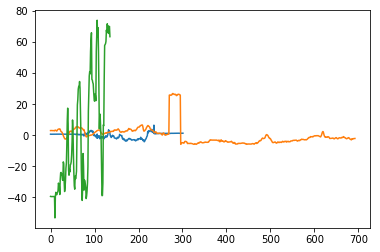

In [19]:
plt.plot(z_score0.T[0])
plt.plot(z_score1.T[0])
plt.plot(z_score2.T[0])
plt.show()

In [20]:
# Moving average

def moving_average(a, n=5) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [21]:
n = 10
# avg0 = np.concatenate([np.zeros((n-1)), moving_average(z_score0.T[0], n)])
# avg1 = np.concatenate([np.zeros((n-1)), moving_average(z_score1.T[0], n)])
# avg2 = np.concatenate([np.zeros((n-1)), moving_average(z_score2.T[0], n)])

avg0 = moving_average(np.concatenate([z_score0.T[0], np.zeros((n-1))]), n)
avg1 = moving_average(np.concatenate([z_score1.T[0], np.zeros((n-1))]), n)
avg2 = moving_average(np.concatenate([z_score2.T[0], np.zeros((n-1))]), n)

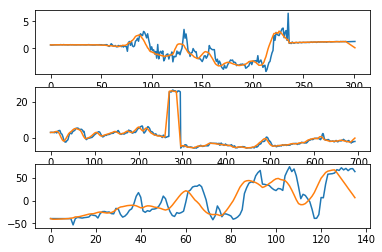

In [22]:
ax0 = plt.subplot(3, 1, 1)
ax0.plot(z_score0.T[0])
ax0.plot(avg0)

ax1 = plt.subplot(3, 1, 2)
ax1.plot(z_score1.T[0])
ax1.plot(avg1)

ax2 = plt.subplot(3, 1, 3)
ax2.plot(z_score2.T[0])
ax2.plot(avg2)

plt.show()

In [26]:
def mov_avg_KNN(n=45):
    new_z1 = np.zeros(z_score1.shape)
#     new_z1[:, 0] = np.concatenate([np.zeros((n-1)), moving_average(z_score1.T[0], n)])
#     new_z1[:, 1] = np.concatenate([np.zeros((n-1)), moving_average(z_score1.T[1], n)])
    new_z1[:, 0] = moving_average(np.concatenate([z_score1.T[0], np.zeros((n-1))]), n)
    new_z1[:, 1] = moving_average(np.concatenate([z_score1.T[1], np.zeros((n-1))]), n)


    new_z2 = np.zeros(z_score2.shape)
#     new_z2[:, 0] = np.concatenate([np.zeros((n-1)), moving_average(z_score2.T[0], n)])
#     new_z2[:, 1] = np.concatenate([np.zeros((n-1)), moving_average(z_score2.T[1], n)])
    new_z2[:, 0] = moving_average(np.concatenate([z_score2.T[0], np.zeros((n-1))]), n)
    new_z2[:, 1] = moving_average(np.concatenate([z_score2.T[1], np.zeros((n-1))]), n)

    score = KNN_detect(testz1=new_z1, testz2=new_z2)
    return score

In [51]:
x = np.arange(1, 60)
y = [mov_avg_KNN(n) for n in x]

<IPython.core.display.Javascript object>


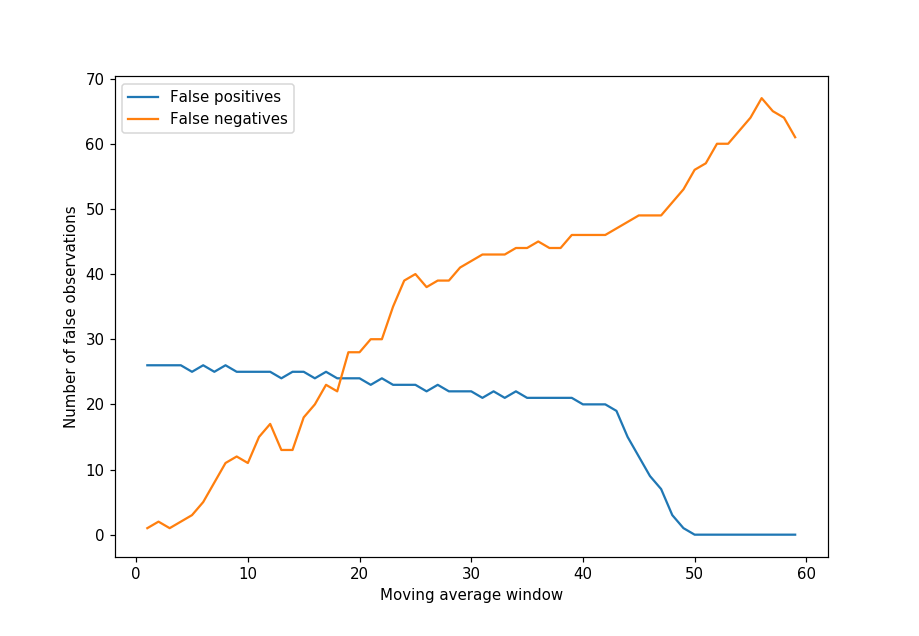

In [60]:
%matplotlib notebook

y_fp = [i[0] for i in y]
y_fn = [i[1] for i in y]

plt.plot(x, y_fp)
plt.plot(x, y_fn)
plt.xlabel('Moving average window')
plt.ylabel('Number of false observations')
plt.legend(['False positives', 'False negatives'])
plt.show()